In [2]:
!pip install scipy

In [44]:
#### This is working properly for the same period of quantile mapping
'''
The taken steps are as follows: 1- Calculates the percentage change between PostFire_realistic and PreFire_base for each quantile.
2- Applies these percentage changes to the corresponding HistAvgFlow values within the same quantiles.
3- Saves the adjusted data to a new CSV file.
This approach adjusts the HistAvgFlow values by a percentage that reflects the change observed between the post-fire and pre-fire scenarios, providing a more nuanced adjustment based on the relative changes observed in the data.
'''
import pandas as pd
import numpy as np


#df = pd.read_csv('Monthly_ave_realistic_cleaner_Q_cfs_Station_MER.csv')
df = pd.read_csv('Monthly_ave_realistic_cleaner_Q_cfs_Station_WFR.csv')


scenario1_col = 'PostFire_realistic'
scenario2_col = 'PreFire_base'
historical_col = 'HistAvgFlow'
month_col = 'Month'  

df[month_col] = df[month_col].astype(int)

quantiles = np.linspace(0, 1, 11)  # 10 quantiles (0%, 10%, 20%, ..., 100%)

df['adjusted_historical'] = np.nan


for month in df[month_col].unique():
    
    df_month = df[df[month_col] == month]

    
    postfire_quantiles = df_month[scenario1_col].quantile(quantiles)
    prefire_quantiles = df_month[scenario2_col].quantile(quantiles)
    historical_quantiles = df_month[historical_col].quantile(quantiles)

    
    quantile_percentage_changes = ((postfire_quantiles - prefire_quantiles) / prefire_quantiles) * 100

    
    for q in quantiles:
        
        adjustment_factor = 1 + (quantile_percentage_changes[q] / 100)

        
        quantile_mask = (df[month_col] == month) & (df[historical_col] <= historical_quantiles[q])

        
        df.loc[quantile_mask, 'adjusted_historical'] = df.loc[quantile_mask, historical_col] * adjustment_factor


df['adjusted_historical'].fillna(df[historical_col], inplace=True)


df.to_csv('bias_corrected_historical_data_monthly_percentage.csv', index=False)


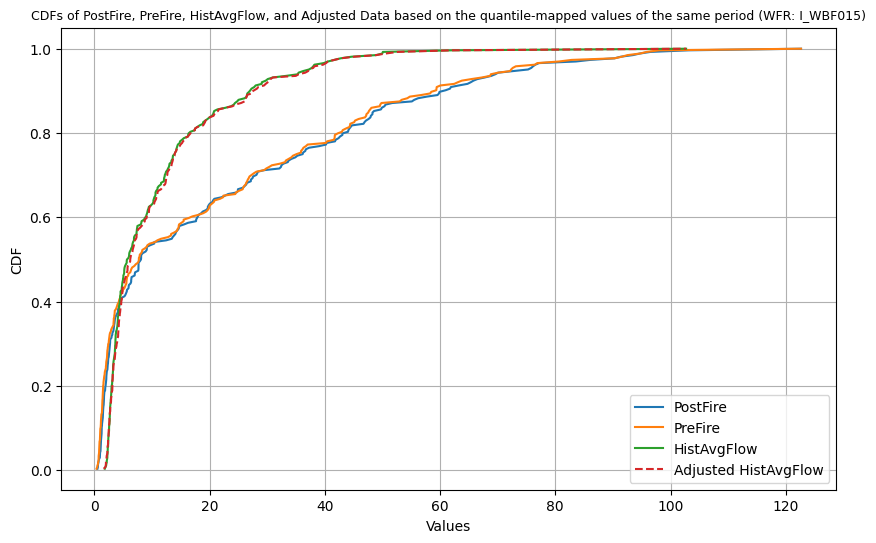

In [46]:
#### This is working properly for plotting the same periods of quantile mapping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv('bias_corrected_historical_data_monthly_percentage.csv')

# Columns
scenario1_col = 'PostFire_realistic'
scenario2_col = 'PreFire_base'
historical_col = 'HistAvgFlow'
adjusted_col = 'adjusted_historical'  # Assuming this is already calculated and added to the DataFrame

# Function to calculate CDF
def calculate_cdf(data):
    # Sort data
    data_sorted = np.sort(data)
    # Calculate CDF values
    cdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
    return data_sorted, cdf

# Calculate CDFs for each dataset
postfire_x, postfire_cdf = calculate_cdf(df[scenario1_col].dropna())
prefire_x, prefire_cdf = calculate_cdf(df[scenario2_col].dropna())
historical_x, historical_cdf = calculate_cdf(df[historical_col].dropna())
adjusted_x, adjusted_cdf = calculate_cdf(df[adjusted_col].dropna())

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(postfire_x, postfire_cdf, label='PostFire')
plt.plot(prefire_x, prefire_cdf, label='PreFire')
plt.plot(historical_x, historical_cdf, label='HistAvgFlow')
plt.plot(adjusted_x, adjusted_cdf, label='Adjusted HistAvgFlow', linestyle='--')

#plt.title('CDFs of PostFire, PreFire, HistAvgFlow, and Adjusted Data based on the quantile-mapped values of the same period (MER: I_MFF019)', fontsize=9)
plt.title('CDFs of PostFire, PreFire, HistAvgFlow, and Adjusted Data based on the quantile-mapped values of the same period (WFR: I_WBF015)', fontsize=9)
plt.xlabel('Values')
plt.ylabel('CDF')
plt.legend()
plt.grid(True)
plt.show()


In [72]:
#### Hamed Zamanisabzi 12-06-2023
#### This is working properly for the different periods of quantile mapping
'''
The taken steps are as follows: 
To implement the quantile mapping method with interpolation for the case where HistAvgFlow covers a longer period than PostFire_realistic and PreFire_base, 
the approach is different than the when we apply to the same period. We'll read data from the three separate sheets of the Excel file and then use interpolation 
to align and map the quantiles across the different time periods. Here's how you can do it:

1- Reading (loading) Data from Different SpreadSheets:

We read/load each sheet into a separate DataFrame.
2- Aligning (index) Data by Month:

Then, we create a consistent monthly time series that can be used for alignment.
3. Quantile Mapping with Interpolation:

We calculate quantile differences or percentage changes for the overlapping period between PostFire_realistic and PreFire_base.
We'll then interpolate these changes to apply them to the entire HistAvgFlow series.

Overall, data from each spreadsheet is loaded into separate DataFrames.
A Date column is created for each DataFrame to align data by month and year.
Quantile percentage changes are calculated for the overlapping period and then interpolated to apply to the entire HistAvgFlow series.
The adjusted_historical values are calculated by applying these interpolated changes.
This approach assumes that the relationships captured in the overlapping period can be reasonably extended to the entire period covered by the HistAvgFlow data. 
The interpolation step bridges the gap where direct quantile mapping isn't possible due to the differing time periods.
'''
import pandas as pd
import numpy as np

# Loading the data from Excel sheets
#file_path = 'Monthly_ave_realistic_cleaner_Q_cfs_Station_MER_L.xlsx'
file_path = 'Monthly_ave_realistic_cleaner_Q_cfs_Station_WFR_L.xlsx'
df_prefire = pd.read_excel(file_path, sheet_name='Sheet1')
df_postfire = pd.read_excel(file_path, sheet_name='Sheet2')
df_hist = pd.read_excel(file_path, sheet_name='Sheet3')


for df in [df_prefire, df_postfire, df_hist]:
    df['Year'] = df['Year'].astype(int)
    df['Month'] = df['Month'].astype(int)


df_prefire['Date'] = pd.to_datetime(df_prefire[['Year', 'Month']].assign(DAY=1))
df_postfire['Date'] = pd.to_datetime(df_postfire[['Year', 'Month']].assign(DAY=1))
df_hist['Date'] = pd.to_datetime(df_hist[['Year', 'Month']].assign(DAY=1))


df_prefire.set_index('Date', inplace=True)
df_postfire.set_index('Date', inplace=True)
df_hist.set_index('Date', inplace=True)

# Quantile Mapping for PostFire and PreFire Scenarios, by Month (101 quantiles (0%, 1%,..., 10%,... 20%, ..., 99%, 100%))
quantiles = np.linspace(0, 1, 101)  


df_hist['adjusted_historical'] = np.nan


for month in range(1, 13):  
    
    postfire_quantiles = df_postfire[df_postfire['Month'] == month]['PostFire_realistic'].quantile(quantiles)
    prefire_quantiles = df_prefire[df_prefire['Month'] == month]['PreFire_base'].quantile(quantiles)

    
    quantile_percentage_changes = ((postfire_quantiles - prefire_quantiles) / prefire_quantiles) * 100

    
    interpolated_changes = np.interp(df_hist[df_hist['Month'] == month]['HistAvgFlow'], historical_quantiles, quantile_percentage_changes)

    
    df_hist.loc[df_hist['Month'] == month, 'adjusted_historical'] = \
        df_hist[df_hist['Month'] == month]['HistAvgFlow'] * (1 + interpolated_changes / 100)


df_hist['adjusted_historical'].fillna(df_hist['HistAvgFlow'], inplace=True)


#df_hist.to_csv('bias_corrected_historical_data_interpolated_MER_I_MFF019.csv')
df_hist.to_csv('bias_corrected_historical_data_interpolated_WFR_I_WBF015.csv')


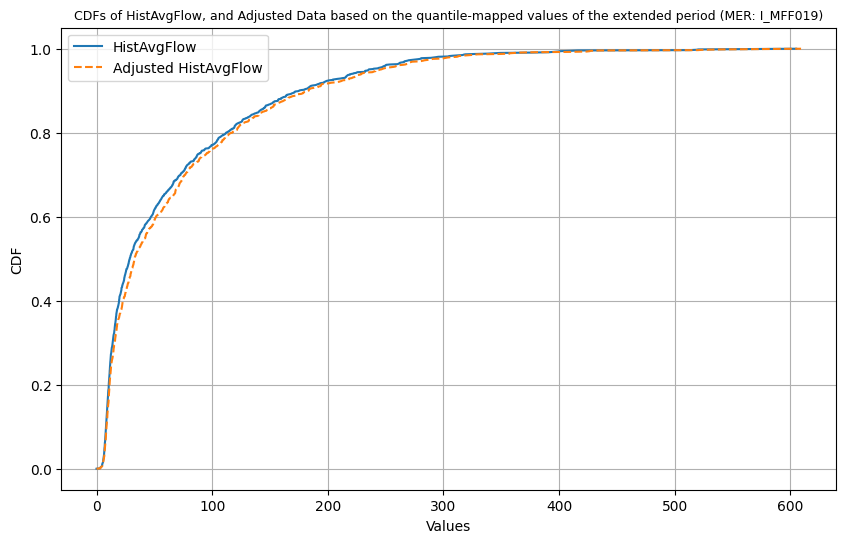

In [71]:
#### Hamed Zamanisabzi 12-06-2023 
###  This is working properly for plotting the different periods of quantile mapping (different quantile period)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv('bias_corrected_historical_data_interpolated_MER_I_MFF019.csv')
#df = pd.read_csv('bias_corrected_historical_data_interpolated_WFR_I_WBF015_test2.csv')


# Columns
#scenario1_col = 'PostFire_realistic'
#scenario2_col = 'PreFire_base'
historical_col = 'HistAvgFlow'
adjusted_col = 'adjusted_historical'  # Assuming this is already calculated and added to the DataFrame


def calculate_cdf(data):
    data_sorted = np.sort(data)
    cdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
    return data_sorted, cdf

# Calculate CDFs for each dataset
#postfire_x, postfire_cdf = calculate_cdf(df[scenario1_col].dropna())
#prefire_x, prefire_cdf = calculate_cdf(df[scenario2_col].dropna())
historical_x, historical_cdf = calculate_cdf(df[historical_col].dropna())
adjusted_x, adjusted_cdf = calculate_cdf(df[adjusted_col].dropna())

# Plotting
plt.figure(figsize=(10, 6))
#plt.plot(postfire_x, postfire_cdf, label='PostFire')
#plt.plot(prefire_x, prefire_cdf, label='PreFire')
plt.plot(historical_x, historical_cdf, label='HistAvgFlow')
plt.plot(adjusted_x, adjusted_cdf, label='Adjusted HistAvgFlow', linestyle='--')



plt.title('CDFs of HistAvgFlow, and Adjusted Data based on the quantile-mapped values of the extended period (MER: I_MFF019)', fontsize=9)
#plt.title('CDFs of HistAvgFlow, and Adjusted Data based on the quantile-mapped values of the extended period (WFR: I_WBF015)', fontsize=9)
plt.xlabel('Values')
plt.ylabel('CDF')
plt.legend()
plt.grid(True)
plt.show()

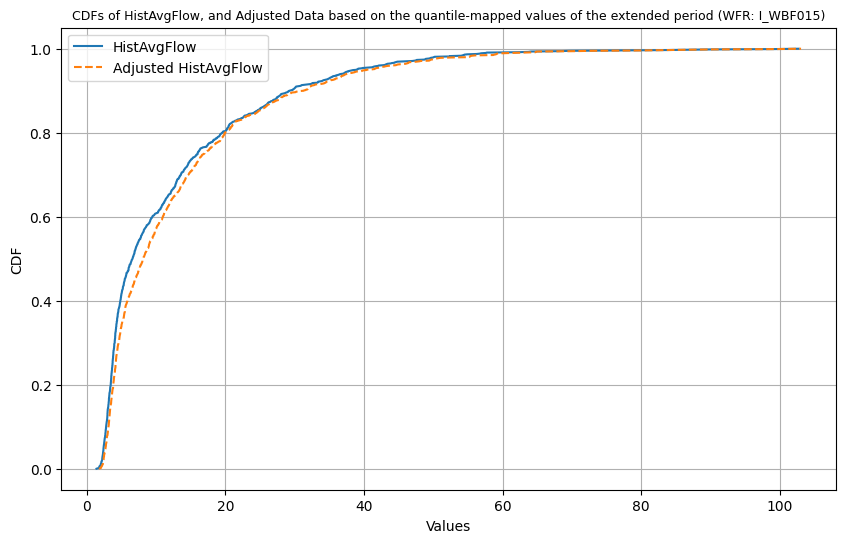

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your data
#df = pd.read_csv('bias_corrected_historical_data_interpolated_MER_I_MFF019.csv')
df = pd.read_csv('bias_corrected_historical_data_interpolated_WFR_I_WBF015.csv')

# Columns
#scenario1_col = 'PostFire_realistic'
#scenario2_col = 'PreFire_base'
historical_col = 'HistAvgFlow'
adjusted_col = 'adjusted_historical'  # Assuming this is already calculated and added to the DataFrame

# Function to calculate CDF
def calculate_cdf(data):
    # Sort data
    data_sorted = np.sort(data)
    # Calculate CDF values
    cdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
    return data_sorted, cdf

# Calculate CDFs for each dataset
#postfire_x, postfire_cdf = calculate_cdf(df[scenario1_col].dropna())
#prefire_x, prefire_cdf = calculate_cdf(df[scenario2_col].dropna())
historical_x, historical_cdf = calculate_cdf(df[historical_col].dropna())
adjusted_x, adjusted_cdf = calculate_cdf(df[adjusted_col].dropna())

# Plotting
plt.figure(figsize=(10, 6))
#plt.plot(postfire_x, postfire_cdf, label='PostFire')
#plt.plot(prefire_x, prefire_cdf, label='PreFire')
plt.plot(historical_x, historical_cdf, label='HistAvgFlow')
plt.plot(adjusted_x, adjusted_cdf, label='Adjusted HistAvgFlow', linestyle='--')

#plt.title('CDFs of PostFire, PreFire, HistAvgFlow, and Adjusted Data based on the quantile-mapped values of the extended period (MER: I_MFF019)', fontsize=9)
plt.title('CDFs of HistAvgFlow, and Adjusted Data based on the quantile-mapped values of the extended period (WFR: I_WBF015)', fontsize=9)
plt.xlabel('Values')
plt.ylabel('CDF')
plt.legend()
plt.grid(True)
plt.show()